In [1]:
%%capture installation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [7]:
class Args:
    batch_size = 1
    device  = "cuda"
    model_name = "cifar10_cnn_1"
    ae_name = "cnn_256"

args = Args()

In [8]:
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, valid_dataloader, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader {config['dataset_name']}!!!!!") 

Working on the dataset: cifar10!!!!!
Loaded classifier and autoencoder models in eval mode!!!!!
Files already downloaded and verified
Files already downloaded and verified
Loaded dataloader cifar10!!!!!


In [9]:
def plot_adversarial_images(images, pgd_adv_images, spgd_adv_images, reshape_size=(28, 28)):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,5,1, xticks=[], yticks=[])
    plt.title("Original")
    plt.imshow(images[0].cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    plt.subplot(1,5,2, xticks=[], yticks=[])
    plt.title("PGD")
    plt.imshow(pgd_adv_images[0].cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    pgd_noise = pgd_adv_images[0] - images[0]
    plt.subplot(1,5,3, xticks=[], yticks=[])
    plt.title("PGD Noise")
    plt.imshow(pgd_noise.cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    plt.subplot(1,5,4, xticks=[], yticks=[])
    plt.title("SemanticPGD")
    plt.imshow(spgd_adv_images[0].cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    spgd_noise = spgd_adv_images[0] - images[0]
    plt.subplot(1,5,5, xticks=[], yticks=[])
    plt.title("SemanticPGD Noise")
    plt.imshow(spgd_noise.cpu().detach().reshape(reshape_size).permute(1, 2, 0))

In [5]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(args.device)
    labels = labels.to(args.device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :  
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(args.device)
        cost.backward()

        # Perturb original image
        adv_images = images + alpha*images.grad.sign()

        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

def semantic_pgd_attack(model, ae_model, images, labels, eps=0.4, alpha=8/255, s_alpha=0.007, iters=100, batch_size=1) :
    images = images.to(args.device)
    labels = labels.to(args.device)
    loss = nn.CrossEntropyLoss()
        
    adv_images = images.clone().detach()
    original_inputs_numpy = images.clone().cpu().detach().numpy()
        
    for i in range(iters) :
        adv_images.requires_grad = True
        # adv_images = adv_images.to(args.device)
        
        # Classifier part
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss(outputs, labels).to(args.device)
        cost.backward()

        # # Perturb original image
        # adv_images = images + alpha*images.grad.sign()

        # # Adjust semantics
        # adv_images = adv_images.detach_()
        # adv_images.requires_grad = True
        # recon_images, _ = ae_model(adv_images)
        # ae_model.zero_grad()

        # Calculate grad w.r.t classifier
        grad_classifier = adv_images.grad.cpu().detach()

        # Autoencoder part
        adv_images.grad = None
        recon_images, _ = ae_model(adv_images)
        ae_model.zero_grad()

        mse_loss = F.mse_loss(adv_images, recon_images).to(args.device)
        mse_loss.backward()

        # Calculate grad w.r.t autoencoder
        grad_autoencoder = adv_images.grad.cpu().detach()

        # Check if the attack is successful
        has_attack_succeeded = (outputs.cpu().detach().numpy().argmax(1)!=labels.cpu().numpy())

        # Calculate the projection of perceptual grad on classifier
        # and grad_autoencoder = grad_autoencoder - (projection of gradient_autoencoder onto gradient_classifier)
        grad_autoencoder_proj = grad_autoencoder - torch.bmm((torch.bmm(grad_autoencoder.view(batch_size, 1, -1), 
                                grad_classifier.view(batch_size, -1, 1)))/(1e-20+torch.bmm(grad_classifier.view(batch_size, 1, -1),
                                grad_classifier.view(batch_size, -1, 1))).view(-1, 1, 1),
                                grad_classifier.view(batch_size, 1, -1)).view(grad_autoencoder.shape)

        # Calculate the projection of classifier grad on autoencoder
        # and grad_classifier = grad_classifier - (projection of gradient_classifier onto gradient_autoencoder)
        grad_classifier_proj = grad_classifier - torch.bmm((torch.bmm(grad_classifier.view(batch_size, 1, -1),
                               grad_autoencoder.view(batch_size, -1, 1)))/(1e-20+torch.bmm(grad_autoencoder.view(batch_size, 1, -1),
                               grad_autoencoder.view(batch_size, -1, 1))).view(-1, 1, 1),
                               grad_autoencoder.view(batch_size, 1, -1)).view(grad_classifier.shape)

        # Combine grads (Selective Gradient Descent)
        # grad = grad_classifier * (1-has_attack_succeeded) - grad_autoencoder * has_attack_succeeded
        grad = grad_classifier_proj * (1-has_attack_succeeded) - (grad_autoencoder_proj) * has_attack_succeeded

        # Add semantic perturbation
        # adv_examples = adv_images - s_alpha * sign_data_grad

        # Apply combined perturbation
        sign_grad = torch.sign(grad).to(torch.float32).to(args.device)
        adv_images = adv_images.detach() + alpha * sign_grad

        eta = torch.clamp(adv_images - torch.tensor(original_inputs_numpy).to(args.device), min=-eps, max=eps)
        adv_images = torch.clamp(torch.tensor(original_inputs_numpy).to(args.device) + eta, min=0, max=1).detach()
            
    return adv_images

Length of validation dataloader: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 32, 32]) torch.Size([2, 3, 32, 32])
Accuracy of test pgd : 0.000000 %
Accuracy of test spgd: 0.000000 %


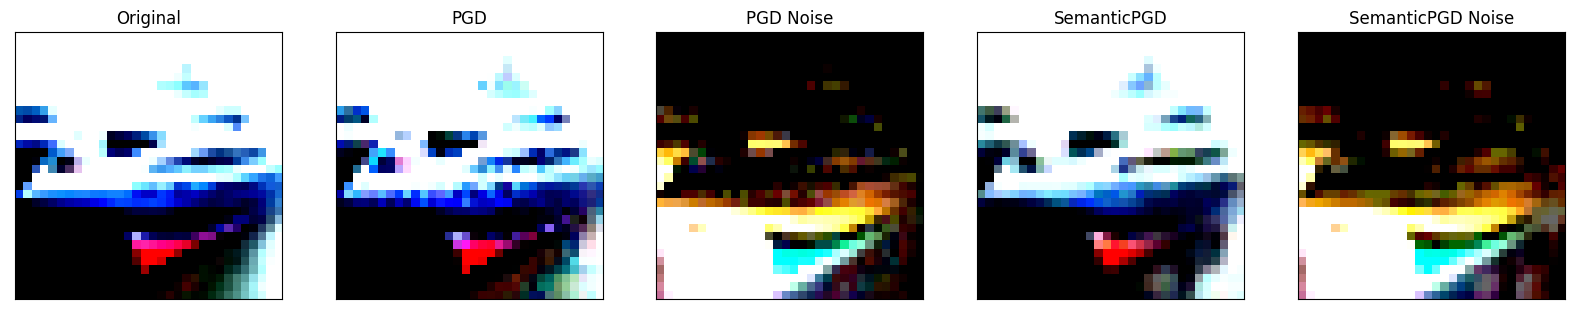

In [14]:
pgd_correct = 0
spgd_correct = 0
total = 0

pgd = []
spgd = []
print(f"Length of validation dataloader: {len(test_dataloader)}")

for i, (images, labels) in enumerate(test_dataloader):
    labels = labels.to(args.device)
    images = images.to(args.device)

    pgd_adv_images = pgd_attack(classifier_model, images, labels)
    spgd_adv_images = semantic_pgd_attack(classifier_model, autoencoder_model, images, labels)
    # print(type(pgd_adv_images), type(spgd_adv_images))
    # print(pgd_adv_images.shape, spgd_adv_images.shape)
    pgd.append(pgd_adv_images)
    spgd.append(spgd_adv_images)

    pgd_outputs = classifier_model(pgd_adv_images)
    spgd_outputs = classifier_model(spgd_adv_images)
    
    _, pgd_pre = torch.max(pgd_outputs.data, 1)
    _, spgd_pre = torch.max(spgd_outputs.data, 1)

    total += 1
    pgd_correct += (pgd_pre == labels).sum()
    spgd_correct += (spgd_pre == labels).sum()
    if i == 1:
        break
    
    # plt.imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

pgd = torch.stack(pgd).reshape((-1, 3, 32, 32))
spgd = torch.stack(spgd).reshape((-1, 3, 32, 32))
print(pgd.shape, spgd.shape)

print('Accuracy of test pgd : %f %%' % (100 * float(pgd_correct) / (total)))
print('Accuracy of test spgd: %f %%' % (100 * float(spgd_correct) / (total)))

plot_adversarial_images(images, pgd_adv_images, spgd_adv_images, reshape_size=(3, 32, 32))

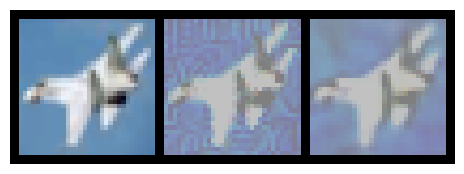

: 

In [7]:
import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

images = images.cpu().detach()
pgd_adv_images = pgd_adv_images.cpu().detach()
spgd_adv_images = spgd_adv_images.cpu().detach()

plot_images(torch.stack([images, pgd_adv_images, spgd_adv_images]))